In [1]:
%matplotlib inline
from edward.util import Progbar
import tensorflow as tf
from utils import generator_xy
import keras
import edward as ed
import numpy as np
from observations import mnist
import matplotlib.pyplot as plt
from edward.models import Normal, Bernoulli, Categorical
import pickle
import seaborn as sns
plt.style.use('ggplot')

Using TensorFlow backend.


In [2]:
sess = tf.InteractiveSession()
ed.set_seed(100)
M = 12000
(x_train, y_train), (x_test, y_test) = mnist('./data')
y_train = tf.cast(y_train, tf.int32).eval()
y_test = tf.cast(y_test, tf.int32).eval()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train_generator = generator_xy([x_train,y_train], M)

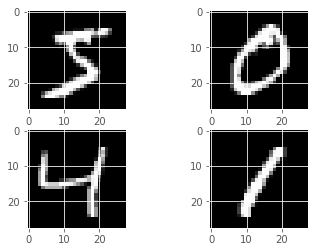

In [3]:
f, axes = plt.subplots(2, 2)
for ax, i in zip(axes.flat[0:], range(4)):
    ax.imshow(x_train[i,:].reshape(28,28),cmap = 'gray')
plt.show()

In [4]:

def auto_encoder(x, W_encode, W_decode, b_endoce, b_decode):
    h = tf.nn.relu(tf.matmul(x,W_encode) + b_encode)
    h = tf.nn.sigmoid(tf.matmul(h,W_decode) + b_decode)
    return h

def mlp(x, W_1, W_2, b_1, b_2):
    h = tf.nn.relu(tf.matmul(x, W_1) + b_1)
    h = tf.nn.softmax(tf.matmul(h, W_2) + b_2)
    return h

def encoder(x, W_encode, b_encode):
    h = tf.nn.relu(tf.matmul(x,W_encode) + b_encode)
    return h

def accuracy(y_true, y_pred):
    correct = 0
    for i in range(len(y_true)):
        if y_true[i] == y_pred[i]:
            correct += 1
        else:
            pass
    return correct/len(y_true)* 1.

In [5]:
W_encode = Normal(loc = tf.zeros([28*28, 32]), scale = 0.01 * tf.ones([28*28, 32]))
W_decode = Normal(loc = tf.zeros([32, 28*28]), scale = 0.01 * tf.ones([32,28*28]))
b_encode = Normal(loc = tf.zeros(32), scale = 0.01 * tf.ones(32))
b_decode = Normal(loc = tf.zeros(28*28), scale = 0.01 * tf.ones(28*28))
W_clf_1  = Normal(loc = tf.zeros([32, 16]), scale = tf.ones([32, 16]))
b_clf_1  = Normal(loc = tf.zeros(16), scale = tf.ones(16)) 
W_clf_2  = Normal(loc = tf.zeros([16,10]), scale = tf.ones([16, 10]))
b_clf_2  = Normal(loc = tf.zeros(10), scale = tf.ones(10))


x = tf.placeholder(tf.float32, [None, 28 * 28])

x_reconstruct = Normal(loc=auto_encoder(x, W_encode, W_decode, b_encode, b_decode),
                      scale = 0.1 *tf.ones([28*28]))
y = Categorical(logits = mlp(encoder(x, W_encode, b_encode) 
                             , W_clf_1, W_clf_2, b_clf_1, b_clf_2))

In [6]:
qW_encode = Normal(loc = tf.Variable(tf.random_normal([28*28,32])),
                  scale = tf.nn.softplus(tf.Variable(tf.random_normal([28*28,32]))))
qW_decode = Normal(loc = tf.Variable(tf.random_normal([32,28*28])),
                  scale = tf.nn.softplus(tf.Variable(tf.random_normal([32,28*28]))))
qb_encode = Normal(loc = tf.Variable(tf.random_normal([32])),
                  scale = tf.nn.softplus(tf.Variable(tf.random_normal([32]))))
qb_decode = Normal(loc = tf.Variable(tf.random_normal([28*28])),
                   scale = tf.nn.softplus(tf.Variable(tf.random_normal([28*28]))))

qW_clf_1 = Normal(loc = tf.Variable(tf.random_normal([32,16])),
                  scale = tf.nn.softplus(tf.Variable(tf.random_normal([32,16]))))
qW_clf_2 = Normal(loc = tf.Variable(tf.random_normal([16,10])),
                  scale = tf.nn.softplus(tf.Variable(tf.random_normal([16,10]))))
qb_clf_1 = Normal(loc = tf.Variable(tf.random_normal([16])),
                  scale = tf.nn.softplus(tf.Variable(tf.random_normal([16]))))
qb_clf_2 = Normal(loc = tf.Variable(tf.random_normal([10])),
                   scale = tf.nn.softplus(tf.Variable(tf.random_normal([10]))))



In [7]:
reconstruct = tf.stack([auto_encoder(x,qW_encode.sample(), 
                                   qW_decode.sample(), qb_encode.sample(), 
                                   qb_decode.sample()) 
                          for _ in range(4)])
tf.global_variables_initializer().run()
out = sess.run(reconstruct, feed_dict = {x: x_train})


(4, 60000, 784)


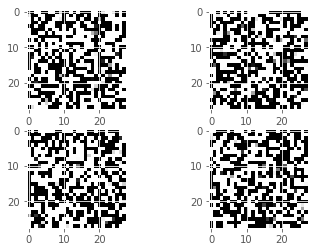

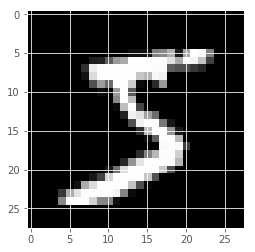

In [8]:
print(out.shape)
f, axes = plt.subplots(2, 2)
for ax, i in zip(axes.flat[0:], range(4)):
    ax.imshow(out[i,0,:].reshape(28,28),cmap = 'gray')
plt.show()
plt.imshow(x_train[0,:].reshape(28, 28), cmap = 'gray')
plt.show()

In [9]:
inference = ed.KLqp({W_encode:qW_encode, b_encode:qb_encode,
                    W_decode:qW_decode, b_decode:qb_decode, 
                    W_clf_1: qW_clf_1, W_clf_2: qW_clf_2, 
                    b_clf_1: qb_clf_1, b_clf_2: qb_clf_2}, 
                    data = {x: x_train, x_reconstruct: x_train, 
                           y: y_train})
inference.initialize(n_iter = 1000, n_samples = 5)
tf.global_variables_initializer().run()


In [10]:
n_epoch = 100
n_iter_per_epoch = x_train.shape[0] // M
log_loss = []
for epoch in range(1, n_epoch + 1):
  print("Epoch: {0}".format(epoch))
  avg_loss = 0.0

  pbar = Progbar(n_iter_per_epoch, verbose = 0)
  for t in range(1, n_iter_per_epoch + 1):
    pbar.update(t)
    x_batch, y_batch = next(x_train_generator)
    info_dict = inference.update(feed_dict={x: x_batch, x_reconstruct: x_batch, 
                                           y: y_batch})
    avg_loss += info_dict['loss']
  avg_loss = avg_loss / n_iter_per_epoch
  avg_loss = avg_loss / M
  log_loss.append(avg_loss)
  print("-log p(x) <= {:0.3f}".format(avg_loss))
    

Epoch: 1
-log p(x) <= 96617.044
Epoch: 2
-log p(x) <= 48204.803
Epoch: 3
-log p(x) <= 39309.185
Epoch: 4
-log p(x) <= 35142.576
Epoch: 5
-log p(x) <= 31669.208
Epoch: 6
-log p(x) <= 28698.641
Epoch: 7
-log p(x) <= 26305.433
Epoch: 8
-log p(x) <= 24348.829
Epoch: 9
-log p(x) <= 22843.838
Epoch: 10
-log p(x) <= 21725.222
Epoch: 11
-log p(x) <= 20791.193
Epoch: 12
-log p(x) <= 20126.327
Epoch: 13
-log p(x) <= 19567.169
Epoch: 14
-log p(x) <= 19077.987
Epoch: 15
-log p(x) <= 18436.845
Epoch: 16
-log p(x) <= 17401.031
Epoch: 17
-log p(x) <= 15500.230
Epoch: 18
-log p(x) <= 13501.496
Epoch: 19
-log p(x) <= 12586.001
Epoch: 20
-log p(x) <= 10943.463
Epoch: 21
-log p(x) <= 9725.199
Epoch: 22
-log p(x) <= 8592.011
Epoch: 23
-log p(x) <= 7509.448
Epoch: 24
-log p(x) <= 6664.961
Epoch: 25
-log p(x) <= 5867.092
Epoch: 26
-log p(x) <= 5235.123
Epoch: 27
-log p(x) <= 4812.819
Epoch: 28
-log p(x) <= 4210.392
Epoch: 29
-log p(x) <= 3928.008
Epoch: 30
-log p(x) <= 4055.998
Epoch: 31
-log p(x) <= 3558.2

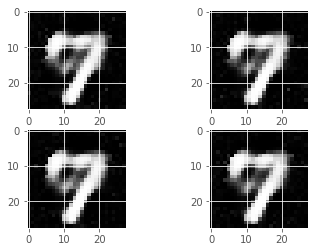

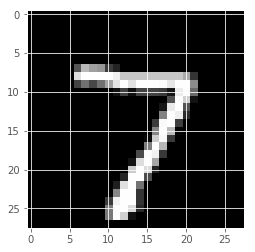

In [15]:
out = sess.run(reconstruct, feed_dict={x: x_test})
f, axes = plt.subplots(2, 2)
for ax, i in zip(axes.flat[0:], range(4)):
    ax.imshow(out[i,0,:].reshape(28,28),cmap = 'gray')
plt.show()
plt.imshow(x_test[0,:].reshape(28, 28), cmap = 'gray')
plt.show()

In [12]:
encode_weights = qW_encode.sample()
encode_bias = qb_encode.sample()
train_encoded = tf.matmul(x_train, encode_weights) + encode_bias
test_encoded = tf.matmul(x_test, encode_weights) + encode_bias
print(train_encoded.eval().shape)
print(test_encoded.eval().shape)
# with open('./data/encoded_train_BAE.pkl','wb') as f:
#     pickle.dump(train_encoded.eval(),f)
# with open('./data/encoded_test_BAE.pkl','wb') as f:
#     pickle.dump(test_encoded.eval(),f)

(60000, 32)
(10000, 32)


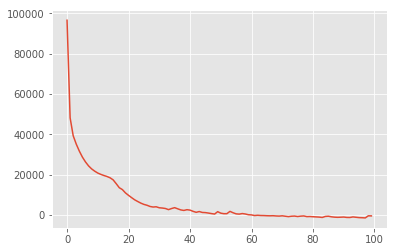

In [16]:
plt.plot(range(100), log_loss)
plt.show()

In [27]:
sample_W1 = qW_clf_1.sample()
sample_W2 = qW_clf_2.sample()
sample_b1 = qb_clf_1.sample()
sample_b2 = qb_clf_2.sample()

y_pred_train = mlp(train_encoded, sample_W1,sample_W2,sample_b1, sample_b2)
y_pred_train = [np.argmax(i) for i in y_pred_train.eval()]

y_pred_test = mlp(test_encoded, sample_W1,sample_W2,sample_b1, sample_b2)
y_pred_test = [np.argmax(i) for i in y_pred_test.eval()]

print(accuracy(y_train, y_pred_train))
print(accuracy(y_test, y_pred_test))

0.84435
0.8392


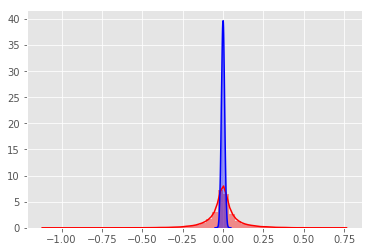

In [18]:
pos_encode = qW_encode.sample().eval()
pri_encode = W_encode.sample().eval()

sns.distplot(np.ndarray.flatten(pos_encode), color = 'red')
sns.distplot(np.ndarray.flatten(pri_encode), color = 'blue')
plt.show()